Using last conv layer: conv2d_2


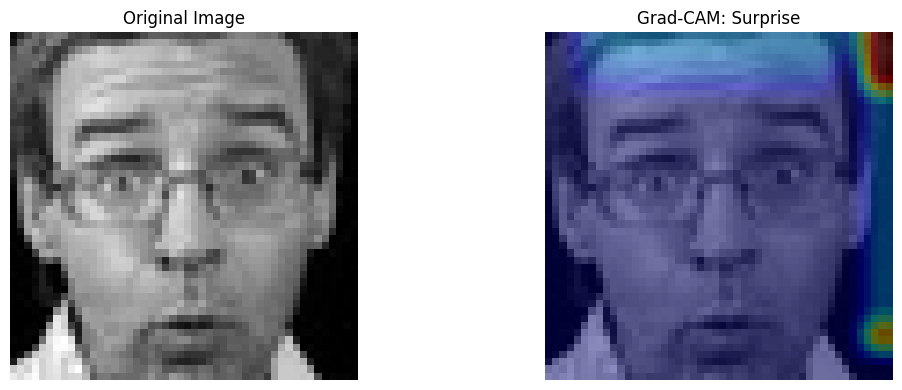

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
import os

# Loading model architecture 
with open("model_a.json", "r") as json_file:
    model_json = json_file.read()
model = model_from_json(model_json)
model.load_weights("model_weights.weights.h5")

#Loading and preprocess image
img_path = "C:/Users/Anshika/Downloads/emotion_detection/train/surprise/Training_991508.jpg"
assert os.path.exists(img_path), f"Image not found at: {img_path}"

img = image.load_img(img_path, color_mode='grayscale', target_size=(48, 48, 1))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0  

# Storing the prediction once to reduce retracing
preds = model.predict(x, verbose=0)
predicted_class = np.argmax(preds[0])
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
predicted_label = emotion_labels[predicted_class]

# Identify last conv layer 
for layer in reversed(model.layers):
    if 'conv' in layer.name:
        last_conv_layer_name = layer.name
        break
print(f"Using last conv layer: {last_conv_layer_name}")

#Grad-CAM Heatmap 
@tf.function(reduce_retracing=True)
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap

#Creating and overlay heatmap 
heatmap = make_gradcam_heatmap(tf.convert_to_tensor(x), model, last_conv_layer_name).numpy()
img_cv = cv2.imread(img_path)
heatmap_resized = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap_color, 0.4, 0)

#Display original and Grad-CAM images 
plt.figure(figsize=(12, 4))

# Original grayscale
original_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.subplot(1, 2, 1)
plt.imshow(original_gray, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Grad-CAM overlay
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM: {predicted_label}")
plt.axis('off')

plt.tight_layout()
plt.show()